In [1]:
# Check Python 2 version
!python -V

Python 2.7.17


In [2]:
# Check Python 3 version
!python3 -V

Python 3.6.9


In [3]:
# Check test dataset files
!ls -l data

total 56
-rw-rw-r-- 1 root root 43101 Jul  5 13:24 first100sp.fasta
-rw-rw-r-- 1 root root  3694 Jul  5 14:56 first10sp.fasta
-rw-r--r-- 1 root root  4133 Jul  1 20:14 simple.fasta


In [4]:
# Dependencies
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess
import tempfile
import random
import time
import sys
import os
import re

# Set random seed
random.seed(42)

# Configure plotting
%matplotlib inline

In [5]:
# Constants
MOBIDB_PATH = '/usr/src/mobidb/mobidb_lite.py'  # Path to MobiDB lite
DATA_PATH = '/usr/src/mobidb/dockertest/data'  # Path to test dataset

In [6]:
def run_mobidb(in_path, out_path='', out_format=0, threads=0, cmd=MOBIDB_PATH, env=os.environ.copy()):
    """Run MobiDB Lite script
    
    Args
    in_path (str)     Path to multi-fasta input file
    out_path (str)    Path to output file, where results are stored (if set)
    out_format (int)  Output format, define output detail. Setting it higher than 0 (default)
                      will require othre dependencies to be correctly in place, rather than
                      the default ones
    cmd (str)         Command for executing MobiDB Lite script
    threads (int)     Number of threads involved in disordered regions computation
    env (dict)        Environmental variables (e.g. python path) which must be set in order
                      to correctly run MobiDB Lite script
    """
    # Call subprocess
    return subprocess.run(
        check=True,  # Check command execution
        encoding='utf-8',  # Set stdout/stderr encoding
        env=env,  # Set environmental variables
        stdout=subprocess.PIPE,  # Capture stdout
        stderr=subprocess.PIPE,  # Capture stderr
        # cwd=cwd,  # Set working directory
        # Command line arguments
        args=[
            # Run script with Python 3
            'python3', cmd,
            # Set output file format
            '-f', '{:d}'.format(out_format),
            # Set output file, if any
            *(['-o', '{:s}'.format(out_path)] if out_path else []),
            # Set number of threads, if any
            *(['-t', '{:d}'.format(threads)] if threads else []),
            # Set input file path
            '{:s}'.format(in_path)
        ]
    )

In [7]:
try:
    # Run MobiDB Lite
    ran = run_mobidb(os.path.join(DATA_PATH, 'simple.fasta'))
    # Check output
    print('MobiDB Lite succesfully completed')
    print('stdout:')
    print(ran.stdout)
    print('stderr:')
    print(ran.stderr)
    print()
except subprocess.CalledProcessError as err:
    # Show error
    print('MobiDB Lite exited with code', err.returncode)
    print('command:')
    print(err.cmd)
    print('stdout:')
    print(err.stdout)
    print('stderr:')
    print(err.stderr)
    print()

MobiDB Lite succesfully completed
stdout:

stderr:
2020-07-07 11:54:31,250 | predictor    | ERROR    | P37840 | seg crashed with error <No such file or directory: '/usr/src/mobidb/binx/seg/bin64/seg'>




In [8]:
# Define function for benchmarking an inner function
def benchmark(fn, **kwargs):
    """Make benchmark of a function
    
    Args
    fn (callable)    Function which must be tested
    kwargs           Other arguments feeded to given function
    
    Return
    (any)            Results taken from function execution
    (float)          Number of seconds it took to execute
    """
    # Initialize timers
    time_beg, time_end = time.time(), None
    
    # Execute function with given parameters
    result = fn(**kwargs)
    
    # Update timers
    time_end = time.time()
    # Return execution time
    return result, float(time_end - time_beg)

In [9]:
# Define ten random sequences samples

# Initialize empty sequences list
sequences = list()
# Open sequences file
with open(os.path.join(DATA_PATH, 'first100sp.fasta'), 'r') as file:
    # Loop through each line in file
    for line in file:
        # Match header
        is_header = re.search(r'^>', line)
        # Case current line is header
        if is_header:
            # Store line as a new entry
            sequences.append(line)
        # Otherwise
        else:
            # Store line in last entry
            sequences[-1] += line
            
# Shuffle sequences
random.shuffle(sequences)

In [10]:
# Define list of "number of threads" parameters
threads = [1, 10, 20, 100]

# Define batch size
batch_size = 10

# Initialize time took dict(batch: list of times)
time_took = dict()

# Try benchmarking of MobiDB Lite predictor with given number of threads
try:
    
    # Do for each sequences batch
    for i in range(0, len(sequences), batch_size):
        # Define current sequences batch
        batch = sequences[i:min(len(sequences), i+batch_size)]
        # Define new temporary input file
        in_file = tempfile.NamedTemporaryFile(suffix='.fasta', delete=False)
        # Write sequences in temporary file
        with open(in_file.name, 'w') as f:
            # Write each sequence
            f.write('\n'.join(batch))
        # Loop through each number of thread
        for j in tqdm(range(len(threads))):
                # Run MobiDB Lite
                ran, sec = benchmark(
                    fn=run_mobidb,  # Tested function
                    cmd=MOBIDB_PATH,  # MobiBD Lite executable path
                    in_path=in_file.name,  # Current batch file
                    # out_path=os.path.join(DATA_PATH, 'out{:d}'.format(i)),  # Output file
                    out_format=0,  # Output format
                    threads=threads[j]  # Number of threads
                )
                # Initialize batches dictionary
                time_took.setdefault(i, list())
                # Save time took
                time_took.get(i).append(sec)

        # Delete temporary file
        os.remove(in_file.name)
    
# Capture eventual errors
except subprocess.CalledProcessError as err:
    # Show error
    print('MobiDB Lite exited with code', err.returncode)
    print(err.stderr)

100%|██████████| 4/4 [00:30<00:00,  7.56s/it]


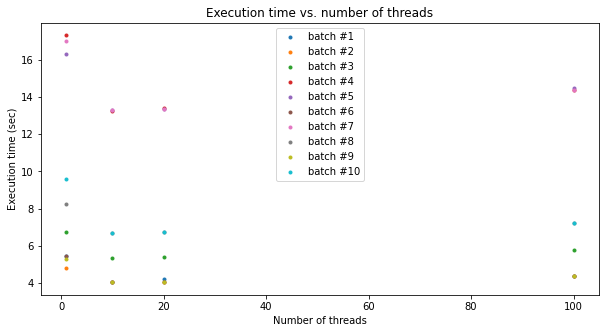

In [11]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Initialize plot
ax.set_title('Execution time vs. number of threads')
ax.set_xlabel('Number of threads')
ax.set_ylabel('Execution time (sec)')

# Loop through all the batches
for i in time_took.keys():
    # Set y axis
    y = [time_took[i][j] for j in range(len(threads))]
    # Set x values
    x = [threads[j] for j in range(len(threads))]
    # Make plot
    ax.plot(x, y, '.')
# Show legend
ax.legend(['batch #{:d}'.format(i+1) for i in range(10)])

# Show plot
plt.show()